In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display, HTML

#import my modules
import acquire as a
import prepare as p
import wrangle_zillow as w
import explore as ex

from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Acquire

In [ ]:
df = a.get_zillow()

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
#getting the latest transactions 
df = df.sort_values(by ='transactiondate', ascending=True).drop_duplicates( subset = 'parcelid' ,keep= 'last')
  

In [ ]:
df.shape

In [ ]:
#this list has all types of single unit properties
single= ['Single Family Residential',' Mobile Home' , 'Townhouse ', 'Manufactured, Modular, Prefabricated Homes'  ]

In [ ]:
#create a mask
single_mask = df['propertylandusedesc'].isin(single)

In [ ]:
#if unitcnt == that's means is is a single property but if it is null we can compare with our list of single

In [ ]:
#using that mask and also add  a condition
df_single = df[single_mask & ((df['unitcnt'] == 1) | (df['unitcnt'].isnull()))]
    

In [ ]:
#this df contains all single unit homes of 2017 with the latest transaction
df_single.shape

In [ ]:
a.summarize(df_single)

**takeaways**
- numberofstories there is one property with 6 stories , I would drop it!
- unitcnt is not needed any more. I would drop it
- there are a lot of nulls so in preparation step I will handle them

# Preparation

In [ ]:
p.miss_dup_values(df_single)

In [ ]:
df_single.shape

In [ ]:
# I will drop columns and rows with a lot of null values 
#here I will include unitcnt because the value is 1 for all the properties . as it is the next to 65.6% 
#I can include it in my function
df_single= p.handle_missing_values(df_single, prop_required_columns=0.75, prop_required_row=0.75)

In [ ]:
df_single.shape

In [ ]:
p.miss_dup_values(df_single)

In [ ]:

#all these  columns represent a minimun amount so I can drop them 
df_single= p.drop_low_missing_values(df_single, per= 3 )

In [ ]:
df_single.shape

In [ ]:
p.miss_dup_values(df_single)

In [ ]:
a.summarize(df_single)

In [ ]:
p.distribution(df_single)

### get county names and create dummy variables with those

In [ ]:
# create dummy vars of fips id
county_df = pd.get_dummies(df_single.fips)

In [ ]:
county_df.head()

- county # 6037 -----> Los Angeles
- county # 6059 -----> Orange
- county # 6111 -----> Ventura

In [ ]:
#df_single = p.get_counties(df_single)

In [ ]:
# print("LA County Verified: ", df_single[df_single.fips==6037]['fips'].count() == df_single.los_angeles.sum())
# print("Orange County Verified: ", df_single[df_single.fips==6059]['fips'].count() == df_single.orange.sum())
# print("Ventura County Verified: ", df_single[df_single.fips==6111]['fips'].count() == df_single.ventura.sum())

In [ ]:
#now in my function I can drop fips

###  Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

**- age**

In [ ]:
df_single['age'] = 2017 - df.yearbuilt

In [ ]:
df_single.head()

In [ ]:
df_single[['age']].describe()

In [ ]:
# I can drop yearbuilt

**- taxrate**


In [ ]:
df_single['taxrate'] = df_single.taxamount/df_single.taxvaluedollarcnt*100

In [ ]:
df_single[['taxrate']].describe()

In [ ]:
# I will drop taxamount and taxvaluedollarcnt

**- transactiondate**


In [ ]:
df_single[['transactiondate']].head()

In [ ]:
#I decided to convert transaction date to int so in the future can make groups

In [ ]:
df_single['transactiondate']=(df_single['transactiondate'].str.replace(' ','').str.replace('-',''))

In [ ]:
df_single['transactiondate'] = df_single['transactiondate'].astype('int')

In [ ]:
#df_single[(df_single.transactiondate >= 20170101) &  (df_single.transactiondate < 20170501)]

In [ ]:
#try to bin transaction date
df_single['quadrimester'] = pd.cut(df_single.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230])

In [ ]:
df_single['quadrimester'].value_counts()

In [ ]:
#this is just to check if bins are correct
#this is the fist quadrimester
(df_single['transactiondate']<20170501).sum()

In [ ]:
#this is the second quadrimester
((df_single['transactiondate']>= 20170501)  & (df_single['transactiondate']<20170901)).sum()

In [ ]:
#this is the third quadrimester
((df_single['transactiondate']>= 20170901)  & (df_single['transactiondate']<20171232)).sum()

In [ ]:
#try to bin transaction date
df_single['quadrimester'] = pd.cut(df_single.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230],
                                 labels = [1,2,3])

In [ ]:
df_single['quadrimester'].value_counts()

In [ ]:
df_single[['transactiondate', 'quadrimester']].sample(30)

In [ ]:
df_single.info()

In [ ]:
df_single['lotsize_acres'] = df_single.lotsizesquarefeet/43560
df_single = df_single.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])

In [ ]:
def create_features (df) :
    '''
    takes in a df and create age , taxrate, lotsize_acres columns and convert transactiondate to int
    drops 'yearbuilt', 'taxamount', 'taxvaluedollarcnt', lotsizesquarefeet columns
    '''
    #create a new colum with age
    df['age'] = 2017 - df.yearbuilt
    
    #taxrate
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100
    
  #transactiondate
    df['transactiondate']=(df['transactiondate'].str.replace(' ','').str.replace('-',''))
    df['transactiondate'] = df['transactiondate'].astype('int')
    #try to bin transaction date
    df['quadrimester'] = pd.cut(df.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230],
                                 labels = [1,2,3])
     # create acres variable
    df['lotsize_acres'] = df.lotsizesquarefeet/43560
    
    #drop columns
    df = df.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])
    
    return df

In [ ]:
p.distribution_boxplot(df_single)

In [ ]:
df_single.columns

In [ ]:
# I will handle outliers for : 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 
#'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age'

In [ ]:
col = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age']

In [ ]:
df_final= p.remove_outliers(df_single, col)

In [ ]:
p.distribution_boxplot(df_final)

In [ ]:
df_final.shape, df_single.shape

In [ ]:
df_final['regionidcity'].value_counts()

In [ ]:
df_final.info()

In [ ]:
# here I can drop
# propertylandusedesc 

In [2]:
#checking wrangle_zillow function
train, validate, test= w.wrangle_zillow()

before outliers (50819, 24)
df shape --> (34126, 23)
train -> (19110, 23)
validate -> (8190, 23)
test -> (6826, 23)


In [3]:
((50819-34126)*100) / 50819

32.847950569668825

In [4]:
X_train, y_train, X_validate, y_validate, X_test, y_test = p.split_Xy(train, validate, test, 'logerror') 

X_train -> (19110, 22)               y_train->(19110,)
X_validate -> (8190, 22)         y_validate->(8190,) 
X_test -> (6826, 22)                  y_test>(6826,)


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19110 entries, 54155 to 12794
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      19110 non-null  object  
 1   bathroomcnt                   19110 non-null  float64 
 2   bedroomcnt                    19110 non-null  float64 
 3   calculatedfinishedsquarefeet  19110 non-null  float64 
 4   latitude                      19110 non-null  float64 
 5   longitude                     19110 non-null  float64 
 6   propertylandusetypeid         19110 non-null  float64 
 7   regionidcity                  19110 non-null  float64 
 8   regionidcounty                19110 non-null  float64 
 9   regionidzip                   19110 non-null  float64 
 10  structuretaxvaluedollarcnt    19110 non-null  float64 
 11  landtaxvaluedollarcnt         19110 non-null  float64 
 12  transactiondate               19110 non-nu

In [6]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,...,transactiondate,county_name,la_cnty,orange_cnty,ventura_cnty,age,taxrate,quadrimester,lotsize_acres,logerror_bins
54155,10820004,2.0,3.0,1433.0,34209445.0,-118505975.0,261.0,12447.0,3101.0,96415.0,...,20170705,Los Angeles,1,0,0,67.0,1.208093,2,0.182484,"(-0.05, 0.05]"
44501,14204400,3.0,3.0,3126.0,33860307.0,-117732319.0,261.0,16764.0,1286.0,97027.0,...,20170608,Orange,0,1,0,25.0,1.063828,2,0.151515,"(-0.05, 0.05]"
77435,11468343,1.0,2.0,806.0,33957244.0,-118391943.0,261.0,12447.0,3101.0,96026.0,...,20170919,Los Angeles,1,0,0,75.0,1.215730,3,0.135560,"(0.05, 0.2]"
43382,13934312,2.0,4.0,1806.0,33790993.0,-117926578.0,261.0,24832.0,1286.0,97047.0,...,20170605,Orange,0,1,0,64.0,1.461827,2,0.167126,"(-0.05, 0.05]"
34022,12837858,2.0,3.0,1851.0,34031627.0,-117917417.0,261.0,118694.0,3101.0,96488.0,...,20170508,Los Angeles,1,0,0,59.0,1.285648,2,0.153926,"(-0.05, 0.05]"


In [7]:
scal_var = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet','latitude', 'longitude', 
            'structuretaxvaluedollarcnt', 'age', 'taxrate', 'lotsize_acres']

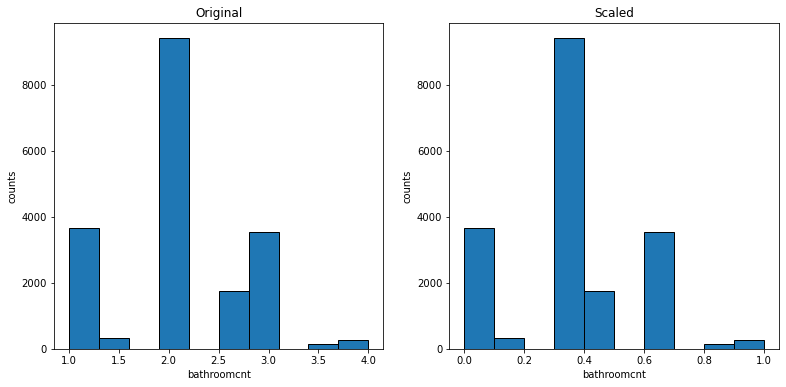

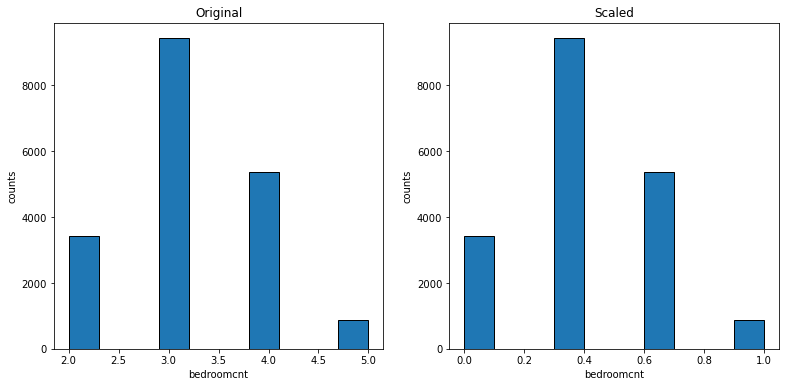

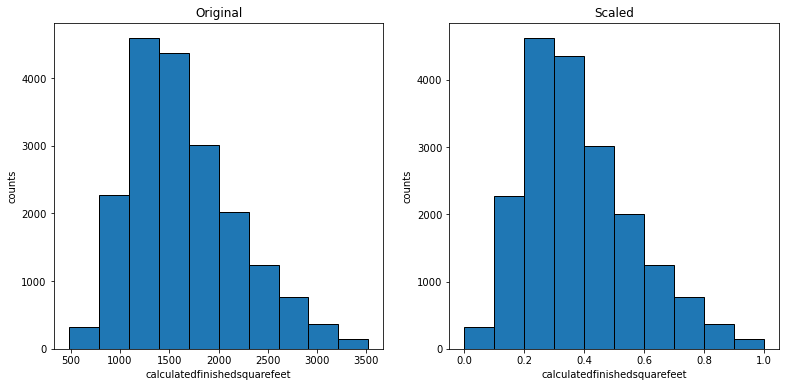

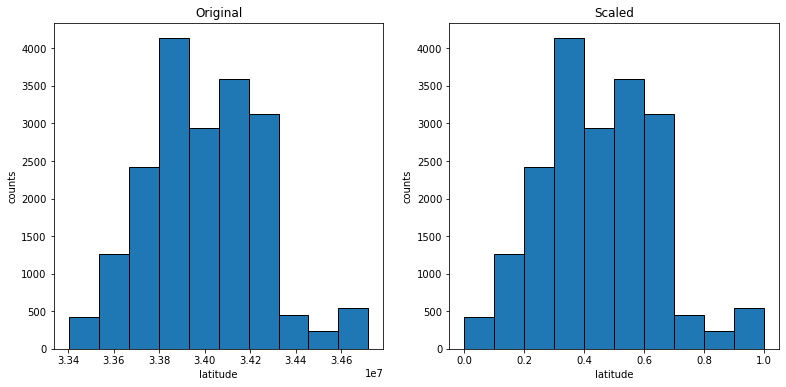

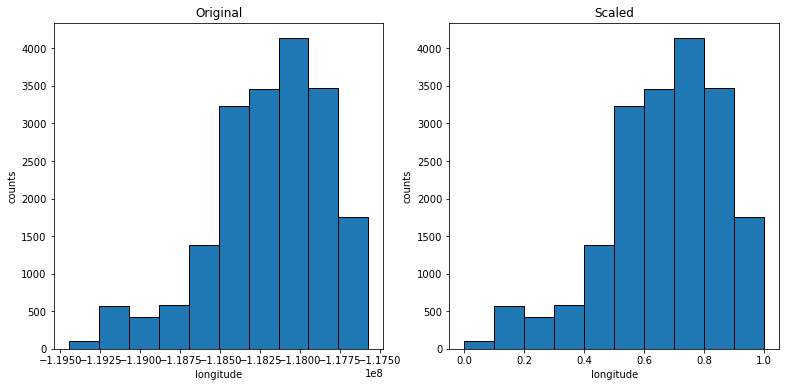

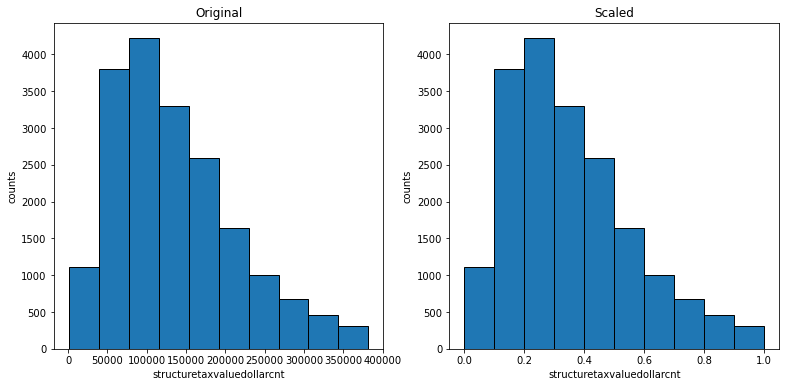

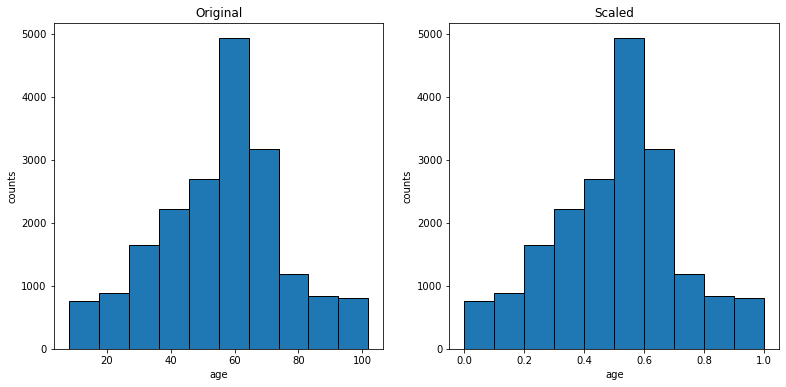

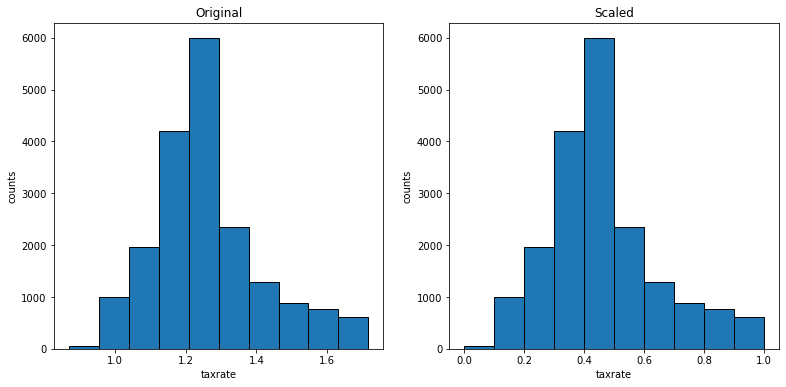

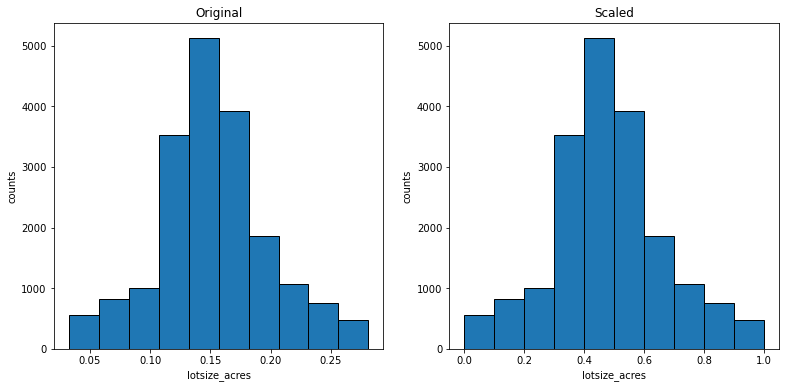

In [8]:
train_scaled_df, validate_scaled_df, test_scaled_df = p.scaled_df( train , validate, test, scal_var, MinMaxScaler())

In [9]:
train_scaled_df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,structuretaxvaluedollarcnt,age,taxrate,lotsize_acres,parcelid,...,regionidzip,landtaxvaluedollarcnt,logerror,transactiondate,county_name,la_cnty,orange_cnty,ventura_cnty,quadrimester,logerror_bins
54155,0.333333,0.333333,0.313487,0.613317,0.502362,0.241588,0.627660,0.399570,0.603730,10820004,...,96415.0,368100.0,-0.028796,20170705,Los Angeles,1,0,0,2,"(-0.05, 0.05]"
44501,0.666667,0.333333,0.870395,0.348033,0.914765,0.819619,0.180851,0.228981,0.479180,14204400,...,97027.0,582701.0,0.003204,20170608,Orange,0,1,0,2,"(-0.05, 0.05]"
77435,0.000000,0.000000,0.107237,0.421688,0.563148,0.176536,0.712766,0.408601,0.415012,11468343,...,96026.0,65798.0,0.093275,20170919,Los Angeles,1,0,0,3,"(0.05, 0.2]"
43382,0.333333,0.666667,0.436184,0.295367,0.811214,0.178186,0.595745,0.699603,0.541963,13934312,...,97047.0,35498.0,-0.010305,20170605,Orange,0,1,0,2,"(-0.05, 0.05]"
34022,0.333333,0.333333,0.450987,0.478206,0.816097,0.370804,0.542553,0.491276,0.488875,12837858,...,96488.0,51930.0,-0.027473,20170508,Los Angeles,1,0,0,2,"(-0.05, 0.05]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10252,0.500000,0.666667,0.656908,0.211511,0.865907,0.661785,0.212766,0.349691,0.215123,14299852,...,96948.0,285302.0,0.015275,20170216,Orange,0,1,0,1,"(-0.05, 0.05]"
21197,0.333333,0.333333,0.266447,0.373502,0.693616,0.303242,0.234043,0.554420,0.185763,12341742,...,96220.0,77600.0,-0.089673,20170329,Los Angeles,1,0,0,1,"(-0.2, -0.05]"
26708,0.333333,0.333333,0.423026,0.586753,0.545401,0.198320,0.489362,0.497725,0.354630,10894280,...,96410.0,36634.0,-0.049205,20170414,Los Angeles,1,0,0,1,"(-0.05, 0.05]"
17123,0.333333,0.333333,0.297368,0.601415,0.127564,0.377636,0.340426,0.393215,0.424892,17149321,...,97106.0,77820.0,0.207205,20170315,Ventura,0,0,1,1,"(0.2, 4.0]"


In [10]:
train_scaled_df.head()


,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,...,transactiondate,county_name,la_cnty,orange_cnty,ventura_cnty,age,taxrate,quadrimester,lotsize_acres,logerror_bins
60337,17124366,2.0,4.0,2436.0,34242629.0,-119039511.0,261.0,51239.0,2061.0,97089.0,...,20170725,Ventura,0,0,1,36.0,1.066761,2,0.211915,"(-0.05, 0.05]"
28178,12668934,2.0,4.0,1521.0,33808478.0,-118388703.0,261.0,33612.0,3101.0,96123.0,...,20170420,Los Angeles,1,0,0,62.0,1.134637,1,0.146602,"(-0.2, -0.05]"
47587,17248766,2.0,4.0,1835.0,34252233.0,-118766999.0,261.0,27110.0,2061.0,97118.0,...,20170616,Ventura,0,0,1,52.0,1.155815,2,0.202479,"(-0.05, 0.05]"
42004,11430808,3.0,3.0,1136.0,33897642.0,-118311162.0,261.0,45398.0,3101.0,96106.0,...,20170531,Los Angeles,1,0,0,70.0,1.254580,2,0.110193,"(-0.05, 0.05]"
76659,17280763,1.0,3.0,932.0,34207657.0,-118851620.0,261.0,34278.0,2061.0,96383.0,...,20170914,Ventura,0,0,1,57.0,1.647027,3,0.280739,"(-0.05, 0.05]"
46984,12252152,2.0,4.0,1640.0,33903547.0,-118295735.0,261.0,45398.0,3101.0,96104.0,...,20170615,Los Angeles,1,0,0,30.0,1.257682,2,0.114210,"(-0.05, 0.05]"
52288,10860050,1.0,3.0,1108.0,34158315.0,-118438305.0,261.0,12447.0,3101.0,96424.0,...,20170629,Los Angeles,1,0,0,69.0,1.242713,2,0.138200,"(0.05, 0.2]"
26089,10829225,2.0,3.0,1316.0,34199897.0,-118453570.0,261.0,12447.0,3101.0,96414.0,...,20170413,Los Angeles,1,0,0,68.0,1.205986,1,0.140702,"(-0.05, 0.05]"
48226,12268960,1.0,3.0,1011.0,33921848.0,-118247414.0,261.0,118994.0,3101.0,96040.0,...,20170620,Los Angeles,1,0,0,71.0,1.541571,2,0.137052,"(-0.05, 0.05]"
38343,12166629,1.0,3.0,1400.0,34186531.0,-118134713.0,261.0,30187.0,3101.0,96265.0,...,20170522,Los Angeles,1,0,0,90.0,1.203363,2,0.164899,"(-5.0, -0.2]"


# Explore 

explore target

In [ ]:
plt.figure(figsize=(13, 8))
train['logerror'].hist(grid=False, color = 'teal')
plt.xlabel("logerror")
plt.ylabel("Number of properties")                               
plt.xlim(-2 ,3)
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(train['logerror'])
plt.xlim(-.25 ,.25)
plt.show()

In [ ]:
train['logerror'].describe()

In [ ]:
train['logerror_bins']= pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

In [ ]:
train.logerror_bins.value_counts()

In [ ]:
ex.plot_variable_pairs(train, 'logerror')

In [ ]:
def plot_variable_pairs(df, target):
    '''
    Takes in a dataframe and a target and returns  plots of all the pairwise relationships 
    along with the regression line for each pair.
    '''
    
    # get the list of the columns  that are not object type
    columns = list(df.select_dtypes(exclude= 'O').columns)
    #remove target from columns
    columns.remove(target)
    
    #plot
    for col in columns:
        sns.lmplot(x= col, y= target, data=df, line_kws={'color': 'red'}, hue = 'logerror_bins')
        plt.title(col)
        plt.show()
    return

In [ ]:
train.columns

In [ ]:
sns.pairplot(data = train, hue = 'logerror_bins',
             x_vars = ['logerror', 'structuretaxvaluedollarcnt', 'quadrimester', 'taxrate', 
                       'bedroomcnt'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'lotsize_acres', 'age'])

takeaways 
- the log error is low for the houses less than 20 years old  that were sold in the 2nd and 3rd quadrimester
- the range of log error is higher for the houses  that are 50 -70 years old
- the range of logerror is low for the lower and higher lot sizes
- the range of logerror is low for the lower and higher calculatedfinishedsqrefeet
- the logerror is low for the calculatedfihishedsquarefeet >1500 and with 4 bedrooms
- the logerror is low for 2.5 -3 bathrooms and were sold jan -dic
- the log error for a 5bedrooms is low with 1 -4 bathrooms except 2 bathrooms
- the range of log error in 3.5 baths is low

In [ ]:
print('Relationship between Age  and logerror)')
sns.jointplot(x='age', y='lotsize_acres', data=train, hue='logerror_bins')
plt.xlabel('Age')
plt.ylabel('lot size')
plt.legend()
plt.show()

In [ ]:
train.head()

In [ ]:
print('Relationship between Age  and logerror)')
sns.jointplot(x='los_angeles', y='logerror', data=train)
plt.xlabel('Age')
plt.ylabel('lot size')
plt.legend('center')
plt.show()

In [ ]:
sns.boxplot(train.age_bin, train.spending_score)
plt.title('Spending Score across age bins')
plt.show()

In [ ]:
def create_cluster(df, X, k):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df['cluster'] = kmeans.predict(X_scaled)
    df['cluster'] = 'cluster_' + df.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids

In [ ]:
def create_scatter_plot(x,y,df,kmeans, X_scaled, scaler):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = df, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')